In [1]:
import numpy as np 
import pandas as pd 
from PIL import Image 
import matplotlib.pyplot as plt 
import cv2 
import yaml 
from sklearn.metrics import roc_curve,auc 

import torch 
from torchvision import transforms 
import torch.nn.functional as F 
import torch.nn as nn 

from src.data.augmentation import *
from src.data.factory import create_dataset,create_dataloader
from src.train import torch_seed
from src.options import Options

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def model_load(root):
    model = torch.load(root)
    return model

def prepare():
    cfg = yaml.load(open('./configs/default.yaml','r'), Loader=yaml.FullLoader)
    cfg['device'] = 'cuda:1'
    torch_seed(cfg['SEED'])

    root = './save_models/BASIC0/best.pt'
    model = model_load(root).to(cfg['device'])
    
    cfg['transform'] = transforms.Compose([transforms.ToTensor()])
    
    
    trainset,testset = create_dataset(
                            cfg      = cfg,
                            data_dir = cfg['datadir'],
                            img_cls  = cfg['imgcls'],
                            img_size = cfg['imgsize'],
                            mode     = cfg['mode']
                            )
    test_loader = create_dataloader(
                            dataset    = testset,
                            batch_size = cfg['Batchsize'],
                            shuffle    = False)

    return cfg,model,testset,trainset,test_loader

def build_anomaly_map(t_features,s_features):
    score_map = 1. 
    for i in range(len(t_features)):
        feature_maps = torch.zeros((len(t_features[0]),len(t_features),cfg['imgsize'],cfg['imgsize']))
        t_f,s_f = t_features[i],s_features[i]
        t_f,s_f = F.normalize(t_f,dim=1), F.normalize(s_f,dim=1)
        
        layer_maps = torch.sum((t_f - s_f)**2,dim=1,keepdim=True)
        layer_maps = F.interpolate(input = layer_maps,
                                size  = (cfg['imgsize'],cfg['imgsize']),
                                mode  = 'bilinear',
                                align_corners = False)
        score_map = score_map*layer_maps
        
        feature_maps[:,i,:,:] = score_map.squeeze(dim=1)
    anomaly_map = torch.mean(feature_maps,dim=1,keepdim=True)  
    return anomaly_map 

def inference(cfg,model,test_loader):
    model.eval()
    device = cfg['device']

    anomaly_map = [] 
    ground_msk = [] 
    for batch_imgs,batch_msks in test_loader:
        
        batch_imgs = batch_imgs.type(torch.float32).to(device)
        t_features,s_features = model(batch_imgs)
        
        batch_anomaly_map = build_anomaly_map(t_features = t_features,
                                            s_features = s_features)
        anomaly_map.extend(batch_anomaly_map.detach().cpu().numpy())
        ground_msk.extend(batch_msks.detach().cpu().numpy())
        
    anomaly_map = np.array(anomaly_map).reshape(len(anomaly_map),-1)      
    ground_msk = np.array(ground_msk).reshape(len(ground_msk),-1)
    ground_msk = np.where(ground_msk==0,ground_msk,1).astype(int)
    
    return anomaly_map,ground_msk

def roc(labels, scores):
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    return roc_auc    


def cal_metric(anomaly_map,ground_msk):
    pixel_roc_auc = roc(ground_msk.flatten(),anomaly_map.flatten())
    img_roc_auc = roc(ground_msk.max(axis=1),anomaly_map.max(axis=1))
    return img_roc_auc,pixel_roc_auc

# Inference Metric 

In [11]:
start = time.time()
cfg,model,testset,trainset,test_loader = prepare()
anomaly_map,ground_msk = inference(cfg,model,testset,trainset,test_loader)
img_roc_auc,pixel_roc_auc = cal_metric(anomaly_map,ground_msk)
end = time.time()
print(img_roc_auc,pixel_roc_auc)
print(end-start)

0.8849999999999999 0.970621812424885
-5.824262619018555


# Inference Visualize 

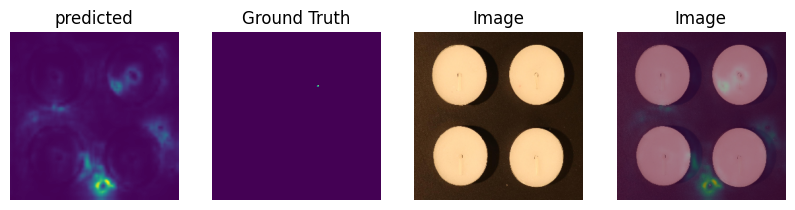

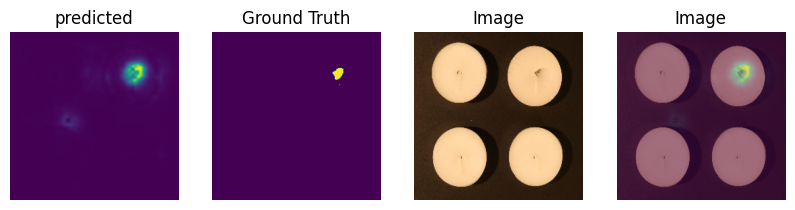

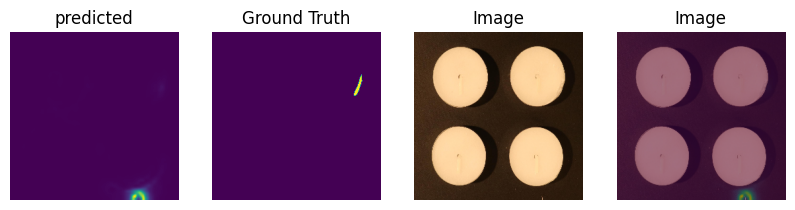

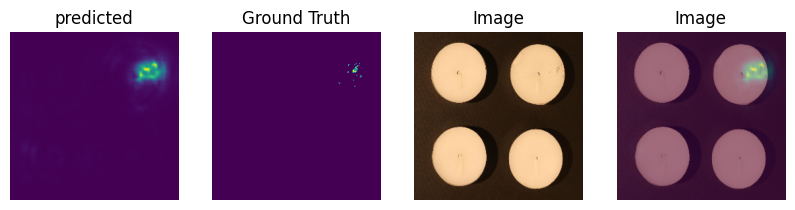

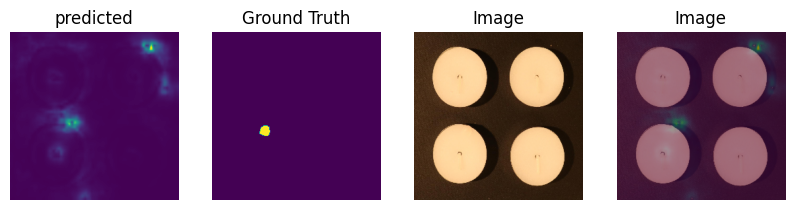

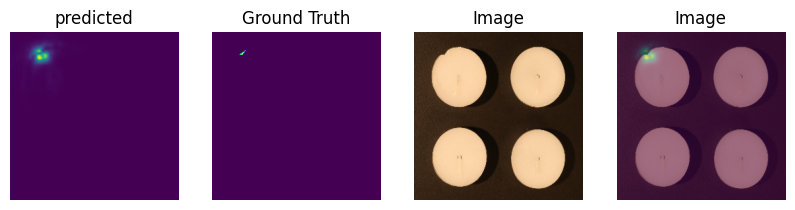

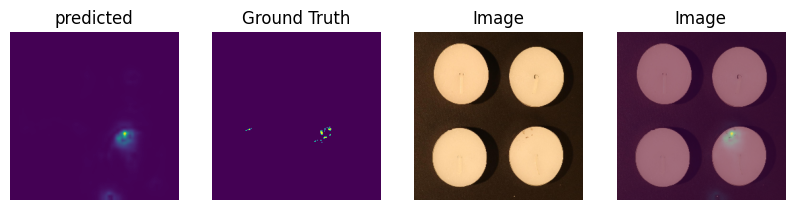

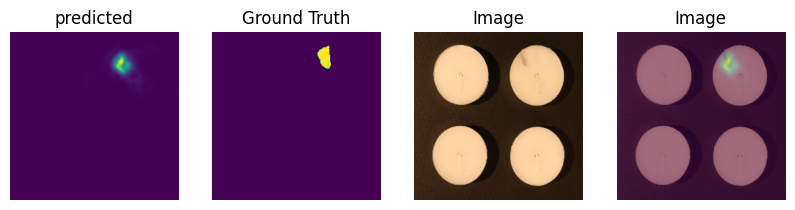

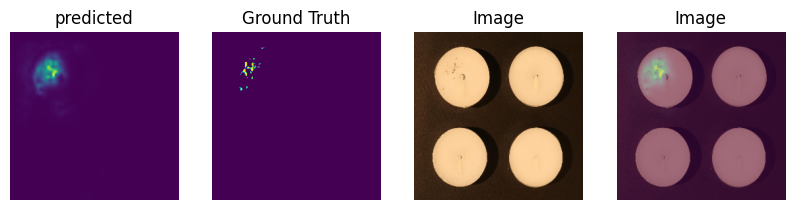

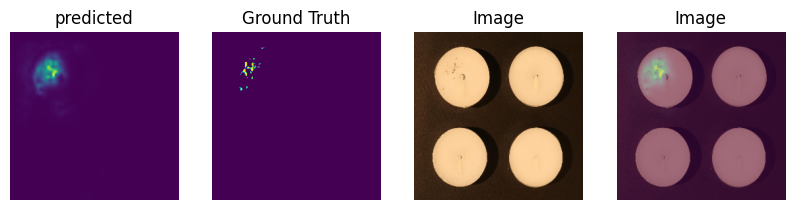

In [7]:
anomaly_idx = np.random.choice(np.where(ground_msk.max(axis=1)==1)[0],10)

for i in anomaly_idx:
    # inference 
    predicted = anomaly_map[i].reshape(cfg['imgsize'],cfg['imgsize'],1)
    gt = ground_msk[i].reshape(cfg['imgsize'],cfg['imgsize'],1)
    # load img 
    img = Image.open(os.path.join(testset.root,testset.img_dirs[i]))
    img = cv2.resize(np.array(img),dsize=(cfg['imgsize'],cfg['imgsize']))
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    #plot 
    fig,axes = plt.subplots(1,4,figsize=(10,10))
    
    axes[0].imshow(predicted)
    axes[0].set_title('predicted')
    axes[0].axis('off')

    axes[1].imshow(gt)
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')

    axes[2].imshow(img)
    axes[2].axis('off')
    axes[2].set_title('Image')
    
    img = cv2.resize(img,dsize=(256,256))
    axes[3].imshow(img)
    axes[3].imshow(predicted,alpha=0.5)
    axes[3].axis('off')
    axes[3].set_title('Image')
    